### Copyright 2023 Google LLC.

### Licensed under the Apache License, Version 2.0 (the "License");

### This colab contains a TensorFlow implementation and a demo of the learning rate scheduler proposed in the paper "Mind the (optimality) Gap: A Gap-Aware Learning Rate Scheduler for Adversarial Nets".


# Learning Rate Scheduler Implementation

Below is a TensorFlow implementation of the scheduler.

In [ ]:
import tensorflow as tf

def lr_scheduler(loss, ideal_loss, x_min, x_max, h_min=0.1, f_max=2.0):
  """Gap-aware Learning Rate Scheduler for Adversarial Networks.

    The scheduler changes the learning rate of the discriminator (D) during 
    training in an attempt to keep D's current loss close to that of D's ideal
    loss, i.e., D's loss when the distribution of the generated data matches
    that of the real data. The scheduler is called at every training step.
    See the paper for more details.

    Let x := abs(loss-ideal_loss) be the optimality gap. The scheduling function
    s(x) is a piecewise function defined as follows:
        f(x) := min(f_max^(x/x_max), f_max)  if loss >= ideal_loss
        h(x) := max(h_min^(x/x_min), h_min)  if loss < ideal_loss.

    When loss >= ideal_loss, the scheduler increases the learning rate in
    proportion to the optimality gap x. At x=x_max, the scheduler reaches its
    maximum value f_max. Similarly, when loss < ideal_loss, the scheduler
    decreases the learning rate. At x=x_min, it reaches the minimum allowed
    value h_min.

    Note: This function outputs s(x), which can be used to multiply the (base)
    learning rate of the optimizer.

    Args:
      loss: the loss of the discriminator D on the training data. In the paper,
        we estimate this quantity by using an exponential moving average of
        the loss of D over all batches seen so far (see the section "Example
        Usage for Training a GAN" in this colab for an example of the
        exponential moving average).
      ideal_loss: the ideal loss of D. See Table 1 in our paper for the
        ideal loss of common GAN loss functions.
      x_min: the value of x at which the scheduler achieves its minimum allowed
        value h_min. Specifically, when loss < ideal_loss, the scheduler
        gradually decreases the LR (as long as x < x_min). For x >= x_min, the
        scheduler's output is capped to the minimum allowed value h_min. In the
        paper we set this to 0.1*ideal_loss.
      x_max: the value of x at which the scheduler achieves its maximum allowed
        value f_max. Specifically, when loss >= ideal_loss, the scheduler
        gradually increases the LR (as long as x < x_max). For x >= x_max, the
        scheduler's output is capped to the maximum allowed value f_max. In the
        paper we set this to 0.1*ideal_loss.
      h_min: a scalar in (0, 1] denoting the minimum allowed value of the
        scheduling function. In the paper we used h_min=0.1.
      f_max: a scalar (>= 1) denoting the maximum allowed value of the 
        scheduling function. In the paper we used h_max=2.0.

    Returns:
      A scalar in [h_min, f_max], which can be used as a multiplier for the
        learning rate of D.
  """

  x = tf.math.abs(loss-ideal_loss)
  f_x = tf.clip_by_value(tf.math.pow(f_max, x/x_max), 1.0, f_max)
  h_x = tf.clip_by_value(tf.math.pow(h_min, x/x_min), h_min, 1.0)
  return tf.cond(loss > ideal_loss, lambda: f_x, lambda: h_x)


# Example Usage for Training a GAN

Below we demonstrate how to use the scheduler for training a GAN on MNIST. We use a DCGAN architecture and the standard non-saturating GAN loss (based on cross-entropy). The ideal loss for this GAN is log(4) (see Table 1 in the paper for more details).

The scheduler is invoked in the last cell, titled "Training Loop".

Note: The architecture and code below are adapted from the official TensorFlow tutorial on DCGAN (https://www.tensorflow.org/tutorials/generative/dcgan).

## Imports

In [ ]:
from math import log
from dataclasses import dataclass
import numpy as np
import matplotlib.pyplot as plt
layers = tf.keras.layers

np.random.seed(1)
tf.random.set_seed(1)

## Define Hyperparams

Set the hyperparams of the GAN, optimizer, and the scheduler.

In [ ]:
@dataclass
class TrainingParams:
  # If true, turn on the learning rate scheduler.
  use_lr_sched: bool = True
  # Base learning rate for Adam.
  lr: float = 1e-3
  # Parameter beta_1 for Adam.
  beta_1: float = 0.5
  num_epochs: int = 50
  batch_size: int = 256
  # Dimension of the noise vector used by the generator.
  noise_dim: int = 128

@dataclass
class SchedulerParams:
  # Since we're using a non-saturating GAN, the ideal loss is log(4).
  ideal_loss: float = log(4)
  x_min: float = 0.1*log(4)
  x_max: float = 0.1*log(4)
  h_min: float = 0.1
  f_max: float = 2.0


training_params = TrainingParams()
scheduler_params = SchedulerParams()

## Load Data

In [ ]:
def load_data():
  (train_images, _), (test_images, _) = tf.keras.datasets.mnist.load_data()
  train_images = train_images.reshape(train_images.shape[0], 28, 28,
                                      1).astype('float32')
  train_images = (train_images - 127.5) / 127.5
  test_images = test_images.reshape(test_images.shape[0], 28, 28,
                                    1).astype('float32')
  test_images = (test_images - 127.5) / 127.5
  valid_images = train_images[50000:]
  train_images = train_images[0:50000]
  return train_images, valid_images, test_images

train_images, _, _ = load_data()
# Shuffle and batch the training data.
training_dataset = tf.data.Dataset.from_tensor_slices(train_images).shuffle(
    60000).batch(training_params.batch_size)

11490434/11490434 [==============================] - 0s 0us/step


## Define Architecture, Loss, Optimizers, and Utility Functions

In [ ]:
def make_generator_model():
  model = tf.keras.Sequential()
  model.add(
      layers.Dense(
          7 * 7 * 256, use_bias=False, input_shape=(training_params.noise_dim,)
      )
  )
  model.add(layers.BatchNormalization(momentum=0.9))
  model.add(layers.ReLU())

  model.add(layers.Reshape((7, 7, 256)))
  assert model.output_shape == (None, 7, 7, 256)
  model.add(
      layers.Conv2DTranspose(
          128, (5, 5), strides=(1, 1), padding='same', use_bias=False
      )
  )
  assert model.output_shape == (None, 7, 7, 128)
  model.add(layers.BatchNormalization(momentum=0.9))
  model.add(layers.ReLU())
  model.add(
      layers.Conv2DTranspose(
          64, (5, 5), strides=(2, 2), padding='same', use_bias=False
      )
  )
  assert model.output_shape == (None, 14, 14, 64)
  model.add(layers.BatchNormalization(momentum=0.9))
  model.add(layers.ReLU())
  model.add(
      layers.Conv2DTranspose(
          1,
          (5, 5),
          strides=(2, 2),
          padding='same',
          use_bias=False,
          activation='tanh',
      )
  )
  assert model.output_shape == (None, 28, 28, 1)
  return model


def make_discriminator_model():
  model = tf.keras.Sequential()
  model.add(
      layers.Conv2D(
          64, (5, 5), strides=(2, 2), padding='same', input_shape=[28, 28, 1]
      )
  )
  model.add(layers.BatchNormalization(momentum=0.9))
  model.add(layers.LeakyReLU())
  model.add(layers.Dropout(0.3))
  model.add(layers.Conv2D(128, (5, 5), strides=(2, 2), padding='same'))
  model.add(layers.BatchNormalization(momentum=0.9))
  model.add(layers.LeakyReLU())
  model.add(layers.Dropout(0.3))
  model.add(layers.Flatten())
  model.add(layers.Dense(1))
  return model

generator = make_generator_model()
discriminator = make_discriminator_model()

cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

def discriminator_loss(real_output, fake_output):
  real_loss = cross_entropy(tf.ones_like(real_output), real_output)
  fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
  total_loss = real_loss + fake_loss
  return total_loss

def generator_loss(fake_output):
  return cross_entropy(tf.ones_like(fake_output), fake_output)


generator_optimizer = tf.keras.optimizers.Adam(training_params.lr,
                                               beta_1=training_params.beta_1)
discriminator_optimizer = tf.keras.optimizers.Adam(training_params.lr,
                                                  beta_1=training_params.beta_1)

# Utility function for visualizing images during training.
def visualize_images(model, test_input):
  predictions = model(test_input, training=False)
  fig = plt.figure(figsize=(8, 8))
  for i in range(predictions.shape[0]):
      plt.subplot(4, 4, i+1)
      plt.imshow(predictions[i, :, :, 0] * 127.5 + 127.5, cmap='gray')
      plt.axis('off')
  plt.show()

## Training Loop

We train the discriminator and generator simultaneously using SGD. The LR scheduler is invoked inside the `train_step` function.

Epoch:  1


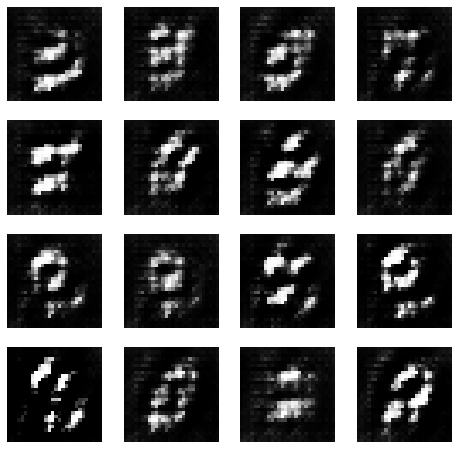

Epoch:  10


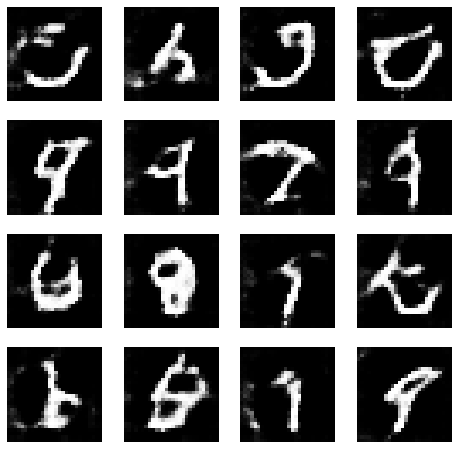

Epoch:  20


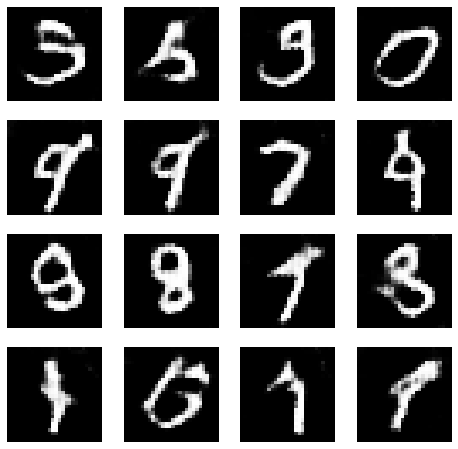

Epoch:  30


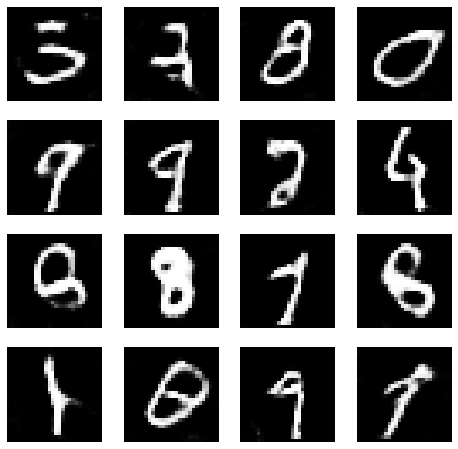

Epoch:  40


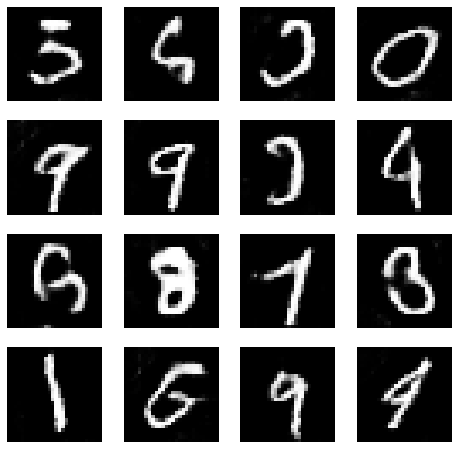

Epoch:  50


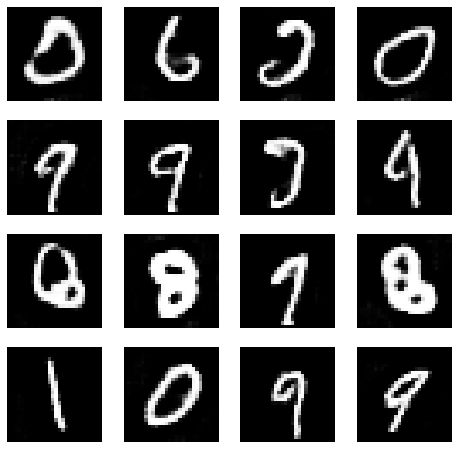

In [ ]:
@tf.function
def train_step(real_images, smoothed_disc_loss):
  """Training step for G and D.

  Runs SGD to simultaneously update G and D. The LR scheduler is invoked inside
  this function. `smoothed_disc_loss` is an exponential moving average of D's
  loss, which is used by the scheduler (as an estimate of D's loss over the
  whole training set). `smoothed_disc_loss` is updated and returned by this
  function after processing the input batch (real_images).

  Args:
    real_images: a batch of real images.
    smoothed_disc_loss: current exponential moving average of D's loss.

  Returns:
    A scalar representing the updated value of smoothed_disc_loss after
      processing the latest training batch.
  """

  noise = tf.random.normal([training_params.batch_size,
                            training_params.noise_dim])

  with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
    generated_images = generator(noise, training=True)

    real_output = discriminator(real_images, training=True)
    fake_output = discriminator(generated_images, training=True)

    gen_loss = generator_loss(fake_output)
    disc_loss = discriminator_loss(real_output, fake_output)

  gradients_of_generator = gen_tape.gradient(gen_loss,
                                              generator.trainable_variables)
  gradients_of_discriminator = disc_tape.gradient(
      disc_loss, discriminator.trainable_variables)

  generator_optimizer.apply_gradients(
      zip(gradients_of_generator, generator.trainable_variables))

  if training_params.use_lr_sched:
    # Update the exponential moving average.
    smoothed_disc_loss = 0.95 * smoothed_disc_loss + 0.05 * disc_loss
    # Call the scheduler and update the LR of D.
    lr = training_params.lr * lr_scheduler(smoothed_disc_loss,
                                scheduler_params.ideal_loss,
                                scheduler_params.x_min,
                                scheduler_params.x_max,
                                scheduler_params.h_min,
                                scheduler_params.f_max)
    discriminator_optimizer.lr.assign(lr)

  discriminator_optimizer.apply_gradients(
      zip(gradients_of_discriminator, discriminator.trainable_variables))

  return smoothed_disc_loss


noise_for_visualization = np.random.normal(size=(16,training_params.noise_dim))

# Initialize smoothed_disc_loss to be equal to ideal_loss.
smoothed_disc_loss = scheduler_params.ideal_loss

# Training loop.
for epoch in range(training_params.num_epochs):
  for image_batch in training_dataset:
    smoothed_disc_loss = train_step(image_batch, smoothed_disc_loss)

  # Visualize every 10 epochs.
  if epoch == 0 or (epoch+1) % 10 == 0:
    print('Epoch: ', epoch+1)
    visualize_images(generator, noise_for_visualization)